In [1]:
from mphelper import ProcessWrapPool
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
from biodatatools.utils.common import json_load
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from collections import defaultdict
import statistics
from pathlib import Path
import os
import sys

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
sys.path.append(f"{Path.cwd().parent}")
import utils

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Generate feature matrix

In [5]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["proximal", "distal"]

In [6]:
acc_target = json_load(f"{PROJECT_DIR_r}ENCODE/acc_target_bw.json")

In [7]:
bws = {}
for acc in acc_target:
	if os.path.exists(f"/fs/cbsuhy02/storage/kl945/Resources/ENCODE/files/{acc}.bigWig"):
		bws[f"{acc_target[acc]}_{acc}"] = f"/fs/cbsuhy02/storage/kl945/Resources/ENCODE/files/{acc}.bigWig"
	else:
		bws[f"{acc_target[acc]}_{acc}"] = f"{PROJECT_DIR_r}ENCODE/{acc}.bigWig"

In [8]:
ms = list(bws.keys())
len(ms)

430

In [9]:
def get_values(m):
	df_features = {}
	use_strand = True
	for p, d in itertools.product(ps, ds):
		bed = f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed"
		all_regions = BEDXReader.read_all(GenomicCollection, bed, strandfield="f7")
		index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]
		df_features[f"{p}_{d}"] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)
	return df_features

In [10]:
pwpool = ProcessWrapPool(15)

map_dict = {}
for m in ms:
	map_dict[m] = pwpool.run(get_values, args=[m])

There could be unexpected exception on multiprocessing. Retrying pid:  152


In [11]:
len(pwpool.finished_tasks)

0

In [25]:
temp = pwpool.get()

In [26]:
df_features = {}
for p, d in itertools.product(ps, ds):
	results = []
	for m in map_dict:
		# Get average values for each position
		results.append(temp[map_dict[m]][f"{p}_{d}"].mean().tolist())
	df_features[f"{p}_{d}"] = pd.DataFrame(results, index=ms)

In [27]:
pwpool.close()

# Cluster ChIP-seq profiles (divergent proximal)

## K-means clustering

In [29]:
zscores = {}
for k in df_features:
	zscores[k] = df_features[k].apply(lambda x: zscore(x), axis=1)

In [30]:
# Get clusters based on divergent proximal group as it shows the clearest patterns

p = "divergent"
d = "proximal"
data = zscores[f"{p}_{d}"].values
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

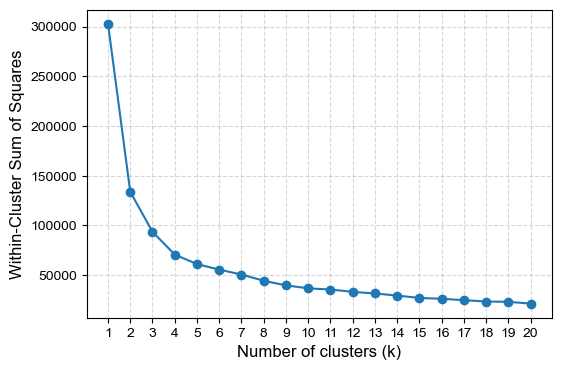

In [31]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(wcss)+1), wcss, marker='o', linestyle='-')
plt.xlabel("Number of clusters (k)", fontsize=bfontsize)
plt.ylabel("Within-Cluster Sum of Squares", fontsize=bfontsize)
plt.xticks(range(1, len(wcss)+1))
plt.grid(True, linestyle='--', alpha=0.5)

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data)

KMeans(n_clusters=4, random_state=42)

In [33]:
df_cluster = zscores[f"{p}_{d}"].copy()
df_cluster['original_cluster'] = kmeans.labels_
# Display the heatmap in a desired order for storyline
mapping = {0: 1, 1: 2, 2: 0, 3: 3}
df_cluster['cluster'] = df_cluster["original_cluster"].map(mapping)
df_cluster = df_cluster.sort_values(by="cluster")
df_cluster.head(2)

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,1000,original_cluster,cluster
CBFA2T3_ENCFF698OFV,-0.936692,-0.937221,-0.938319,-0.938202,-0.938230,-0.938680,-0.938291,-0.937908,-0.937834,-0.938565,...,-0.902411,-0.901666,-0.90077,-0.899854,-0.898050,-0.897662,-0.897116,-0.896038,2,0
RBM25_ENCFF281TJW,-0.551178,-0.553427,-0.552991,-0.552301,-0.554577,-0.555089,-0.556967,-0.558661,-0.558121,-0.555817,...,-0.470263,-0.468783,-0.46658,-0.463171,-0.458672,-0.455383,-0.454304,-0.448922,2,0


## Check consistency

In [34]:
# Get cluster label for each dataset

labels = defaultdict(list)
for index, row in df_cluster.iterrows():
	target = index.split("_")[0]
	labels[target].append(row["cluster"])

In [35]:
# Check consistency of cluster label for proteins with multiple datasets

results = []
major_class = {}
for target in labels:
	if len(labels[target]) > 1:
		mode = statistics.mode(labels[target])
		count = labels[target].count(mode)
		results.append([target, len(labels[target]), count/len(labels[target]), [f"cluster{int(n+1)}" for n in labels[target]]])
		if count/len(labels[target]) > 0.5:
			major_class[target] = mode
df_freq = pd.DataFrame(results, columns=["target", "n_datasets", "major_class_frequency", "clusters"])
df_freq.head(2)

,target,n_datasets,major_class_frequency,clusters
0,ZNF407,2,1.0,"[cluster1, cluster1]"
1,EP300,2,1.0,"[cluster1, cluster1]"


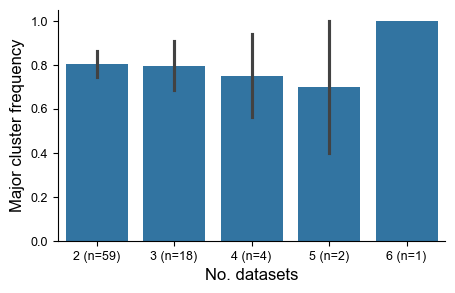

In [36]:
fig, ax = plt.subplots(figsize=(5,3))
g = sns.barplot(data=df_freq, x="n_datasets", y="major_class_frequency", ax=ax)
g.spines[["top", "right"]].set_visible(False)
g.set_xlabel("No. datasets", fontsize=bfontsize)
g.set_ylabel("Major cluster frequency", fontsize=bfontsize)
xticklabels = g.get_xticklabels()
new_xtcklabels = []
for label in xticklabels:
	n_datasets = int(label.get_text())
	n_targets = len(df_freq[df_freq['n_datasets']==n_datasets])
	new_xtcklabels.append(f"{n_datasets} (n={n_targets})")
g.set_xticks(g.get_xticks())
g.set_xticklabels(new_xtcklabels)
g.tick_params(labelsize=sfontsize)

In [43]:
# Proteins with 1 databset: keep all
# Proteins with multiple datasets: if more than half of the datasets assigned the protein to the same cluster, inconsistent datasets were removed; otherwise, all datasets for that protein were excluded.

datasets_keep = []
for dataset, row in df_cluster.iterrows():
	target, exp_id = dataset.split("_")
	if len(labels[target]) == 1:
		datasets_keep.append(dataset)
	elif target in major_class and major_class[target] == row["cluster"]:
		datasets_keep.append(dataset)

In [44]:
# No. datasets, No. targets

len(datasets_keep), len(set([dataset.split("_")[0] for dataset in datasets_keep]))

(359, 282)

# All TRE categories

## Heatmap

In [106]:
# Assign the same cluster labels for other TRE categories

cluster_mapping = defaultdict(set)
df_cluster_filtered = df_cluster.loc[datasets_keep]
for index, row in df_cluster_filtered.iterrows():
	cluster_mapping[row["cluster"]].add(index)

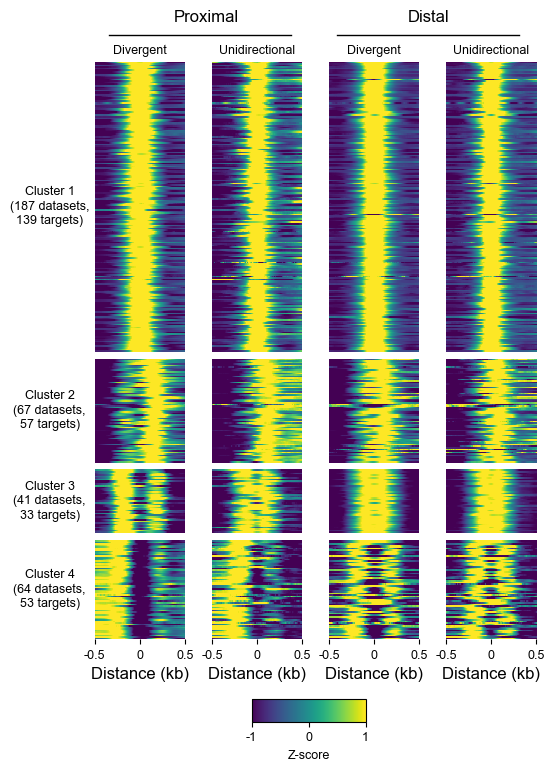

In [171]:
vlims = [-1,0,1]
fig, axes = plt.subplots(4, 4, figsize=(5.7,7.5), gridspec_kw={'height_ratios': [len(cluster_mapping[n]) for n in cluster_mapping]})
for d, p in itertools.product(ds, ps):
	col = ds.index(d)*2 + ps.index(p)
	for row in range(4):
		df = zscores[f"{p}_{d}"].loc[list(cluster_mapping[row])]
		g = sns.heatmap(df, xticklabels=False, yticklabels=False, cbar=None, cmap="viridis", vmin=vlims[0], vmax=vlims[-1], ax=axes[row, col])
		
		if col == 0:
			datasets = list(df_cluster_filtered[df_cluster_filtered["cluster"]==row].index)
			n_datasets = len(datasets)
			n_targets = len(set([k.split("_")[0] for k in datasets]))
			text = f"Cluster {row+1}\n({n_datasets} datasets,\n{n_targets} targets)"
			g.text(-500, 0.5*(df.shape[0]-1), text, fontsize=sfontsize, rotation=0, ha='center', va='center')

		if row == 0:
			g.set_title(p.capitalize(), fontsize=sfontsize)
		else:
			g.set_title("")

		if row == 3:
			xtick_list = [0, 500, 1000]
			xticklabel_list = ["-0.5", "0", "0.5"]
			g.set_xticks(xtick_list)
			g.set_xticklabels(xticklabel_list)
			g.set_xlabel("Distance (kb)", fontsize=bfontsize)
			g.tick_params(labelsize=sfontsize)
		else:
			g.set_xticks([])
			g.set_xlabel("")
			
cbar_ax = fig.add_axes([0.4, 0, 0.2, 0.03])
cbar = plt.colorbar(g.collections[0], cax=cbar_ax, orientation="horizontal")
cbar.set_ticks(vlims)
cbar.set_ticklabels(vlims)
cbar.ax.tick_params(labelsize=sfontsize) 
cbar.set_label("Z-score", fontsize=sfontsize)

fig.text(0.32, 0.93, "Proximal", ha='center', va='bottom', fontsize=bfontsize)
fig.text(0.71, 0.93, "Distal", ha='center', va='bottom', fontsize=bfontsize)
line_y = 0.915
fig.add_artist(Line2D([0.15, 0.47], [line_y, line_y], transform=fig.transFigure, color='black', lw=1))
fig.add_artist(Line2D([0.55, 0.87], [line_y, line_y], transform=fig.transFigure, color='black', lw=1))

fig.subplots_adjust(wspace=0.3, hspace=0.05)
outputfile = f"{PROJECT_DIR_o}figures/SuppFig1a.png"
plt.savefig(outputfile, bbox_inches="tight", dpi=300, transparent=True) 

## Metaplots

In [137]:
# For proteins with multiple datasets, use average values across datasets

df_reformat = {}
for k, cluster in itertools.product(list(zscores), list(cluster_mapping)):
	df = zscores[k].loc[list(cluster_mapping[cluster])]
	df["target"] = df.index.str.split("_").str[0]
	df2 = df.groupby("target").mean().reset_index()
	df_reformat[(k,cluster)] = pd.melt(df2,
									  id_vars="target",
									  value_vars=list(df2.columns[1:]),
									  var_name="Position",
									  value_name="Feature"
									  )

In [139]:
# Get metaplots for each cluster: divergent and unidirectional in the same subplot

df_metaplots = {}
for d, cluster in itertools.product(ds, list(cluster_mapping)):
	dfs = []
	for p in ps:
		df = df_reformat[(f"{p}_{d}",cluster)].copy()
		df["Label"] = p.capitalize()
		dfs.append(df)
	df_metaplots[(d, cluster)] = pd.concat(dfs).reset_index(drop=True)

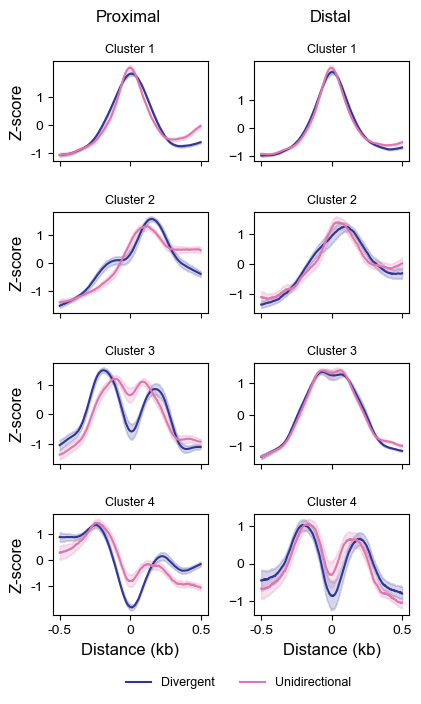

In [178]:
fig, axes = plt.subplots(4, 2, figsize=(4.6,7.2))
for d, cluster in itertools.product(ds, list(cluster_mapping)):
	row = list(cluster_mapping).index(cluster)
	col = ds.index(d)
	ax = axes[row, col]
	
	utils.generate_feature_metaplot(df_metaplots[(d, cluster)], palette=["#313695", "#de77ae"], hue_order=["Divergent", "Unidirectional"], ax=ax, test=False)

	ax.set_title(f"Cluster {int(cluster+1)}", fontsize=sfontsize)

	ax.set_yticks([-1,0,1])
	if col == 0:
		ax.set_ylabel("Z-score", fontsize=bfontsize)
		ax.set_yticklabels([-1,0,1])
	else:
		ax.set_ylabel("")

	ax.set_xticks([0,500,1000])
	if row == 3:
		ax.set_xticklabels([-0.5,0,0.5])
		ax.set_xlabel("Distance (kb)", fontsize=bfontsize)
	else:
		ax.set_xticklabels([])
		ax.set_xlabel("")

	if row == 3 and col == 0:
		ax.legend(loc="upper left", bbox_to_anchor=(0.4,-0.5), ncols=2, fontsize=sfontsize, frameon=False)
	else:
		ax.legend([],[],frameon=False)

fig.text(0.29, 0.93, "Proximal", ha='center', va='bottom', fontsize=bfontsize)
fig.text(0.73, 0.93, "Distal", ha='center', va='bottom', fontsize=bfontsize)

fig.subplots_adjust(wspace=0.3, hspace=0.5)
outputfile = f"{PROJECT_DIR_o}figures/SuppFig1b.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True) 